In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns


Read the data
===========

In [2]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')


x_original['max']=np.min(x_original[['FIELD_6','FIELD_7']],axis=1)
x_original=x_original.drop(columns=['FIELD_6','FIELD_7'])
x_original=x_original.query('FIELD_16 != 1 and FIELD_23 != 1')

y_original['max']=np.min(y_original[['FIELD_6','FIELD_7']],axis=1)
y_original=y_original.drop(columns=['FIELD_6','FIELD_7'])
y_original=y_original.query('FIELD_16 != 1 and FIELD_23 != 1')



In [8]:

x=x_original[['Unnamed: 0','L190400', 'L190500', 'L190700', 'L190300', 'L190800',
       'L190900', 'L104500', 'L104300', 'L103100', 'S000300', 'S000100',
       'S000501', 'L101300', 'L103000', 'L100700',
              
             'FIELD_15','FIELD_17','FIELD_22','FIELD_24','FIELD_16','FIELD_23','AGE','SEX']]

y=y_original[['Unnamed: 0','L190400']]

print(x_original.shape)
print(y_original.shape)

(159381, 407)
(159381, 407)


Prepare the data
============

In [9]:
data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.query('FIELD_15 !=1 and FIELD_17 !=1 and FIELD_22 != 1 and FIELD_24 != 1 and FIELD_16 != 1 and FIELD_23 != 1')

# data=data[data.SEX==0]
# data=data[data.AGE>=40]
data=data.dropna(). reset_index()

# data=data[data.FIELD_15!=1]
# data=data[data.FIELD_17!=1]
# data=data[data.FIELD_22!=1]
# data=data[data.FIELD_24!=1]

# data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
# data=data.drop(columns=['FIELD_6','FIELD_7'])
# data=data.query('FIELD_16 != 1 and FIELD_23 != 1')


print(data.shape)
data.head()

(76749, 26)


,index,Unnamed: 0,L190400_x,L190500,L190700,L190300,L190800,L190900,L104500,L104300,...,L100700,FIELD_15,FIELD_17,FIELD_22,FIELD_24,FIELD_16,FIELD_23,AGE,SEX,L190400_y
0,0,0,12.3,38.2,29.3,4.20,32.2,13.2,70.0,351.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,1.0,13.1
1,1,1,13.1,39.0,30.8,4.24,33.6,13.7,221.0,104.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,1.0,12.9
2,2,2,12.9,38.4,30.2,4.26,33.5,14.1,286.0,144.0,...,3.8,0.0,0.0,0.0,0.0,0.0,0.0,46.0,1.0,11.2
3,3,3,13.5,40.3,32.1,4.20,33.5,13.3,138.0,135.0,...,3.7,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,12.6
4,4,4,12.6,38.6,32.1,3.92,32.6,13.2,130.0,161.0,...,3.4,0.0,0.0,0.0,0.0,0.0,0.0,52.0,1.0,13.5


Check the correlation of the selected feature with the independent variables
=====

In [10]:
temppd=pd.DataFrame(data.copy()[['SEX', 'L190400_x', 'L190500', 'L190700', 'L190300', 'L190800',
       'L190900', 'L104500', 'L104300', 'L103100', 'S000300', 'S000100',
       'S000501', 'L101300', 'L103000', 'L100700'
                                ]]).dropna() 
temppd['y']=data.L190400_y
temppd.corr().head(20)
# corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

# corr = (temppd.corr())
# sns.heatmap(corr, vmin=-1, vmax=1)

# # mask = np.zeros_like(corr)
# # mask[np.triu_indices_from(mask)] = True
# # with sns.axes_style("white"):
# #     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

# corr.head(20)

,SEX,L190400_x,L190500,L190700,L190300,L190800,L190900,L104500,L104300,L103100,S000300,S000100,S000501,L101300,L103000,L100700,y
SEX,1.000000,-0.739543,-0.725681,-0.220785,-0.674003,-0.304960,0.122544,0.292095,-0.231460,0.416583,-0.421350,-0.726041,-0.398025,-0.317453,-0.323101,-0.625437,-0.735252
L190400_x,-0.739543,1.000000,0.965249,0.415057,0.843840,0.483211,-0.320282,-0.383415,0.361373,-0.308310,0.374007,0.542548,0.378315,0.339973,0.319597,0.544601,0.859473
L190500,-0.725681,0.965249,1.000000,0.290032,0.880695,0.241555,-0.244332,-0.336169,0.332935,-0.278989,0.355947,0.536377,0.370611,0.327056,0.294396,0.523315,0.832289
L190700,-0.220785,0.415057,0.290032,1.000000,-0.134106,0.614191,-0.538652,-0.473356,0.338156,-0.021788,0.036787,0.148990,0.057743,0.069119,0.086404,0.128072,0.348886
L190300,-0.674003,0.843840,0.880695,-0.134106,1.000000,0.166359,-0.037613,-0.144454,0.196617,-0.321175,0.384071,0.502058,0.376517,0.328445,0.294926,0.517456,0.730082
L190800,-0.304960,0.483211,0.241555,0.614191,0.166359,1.000000,-0.422074,-0.328185,0.241688,-0.199188,0.185183,0.209917,0.152070,0.156106,0.189370,0.261141,0.405607
L190900,0.122544,-0.320282,-0.244332,-0.538652,-0.037613,-0.422074,1.000000,0.360048,-0.204391,0.069080,-0.022885,-0.108931,-0.019702,-0.038247,-0.030706,-0.078339,-0.279841
L104500,0.292095,-0.383415,-0.336169,-0.473356,-0.144454,-0.328185,0.360048,1.000000,-0.744633,0.100520,-0.038694,-0.223162,-0.030995,-0.056441,-0.006981,-0.156935,-0.363914
L104300,-0.231460,0.361373,0.332935,0.338156,0.196617,0.241688,-0.204391,-0.744633,1.000000,-0.007329,0.070823,0.168515,0.089736,0.121970,0.063782,0.179556,0.296375
L103100,0.416583,-0.308310,-0.278989,-0.021788,-0.321175,-0.199188,0.069080,0.100520,-0.007329,1.000000,-0.404900,-0.295397,-0.209775,-0.230780,-0.421138,-0.317115,-0.343765


In [12]:
y=data[['L190400_y']]

x=data[['SEX', 'L190400_x', 'L190500', 'L190700', 'L190300', 'L190800',
       'L190900', 'L104500', 'L104300', 'L103100', 'S000300', 'S000100',
       'S000501', 'L101300', 'L103000', 'L100700']]
print(x.columns)

Index(['SEX', 'L190400_x', 'L190500', 'L190700', 'L190300', 'L190800',
       'L190900', 'L104500', 'L104300', 'L103100', 'S000300', 'S000100',
       'S000501', 'L101300', 'L103000', 'L100700'],
      dtype='object')


Apply PCA
===========

In [13]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [14]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [15]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [16]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

Random Forest Regressor
=============

In [19]:
ylable=y[['L190400_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [20]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[5.93453619e-01 3.87183890e-01 1.28533337e-03 1.80137516e-03
 7.82904938e-04 1.50974793e-03 2.25122846e-03 3.12039724e-03
 1.56535737e-03 2.53230589e-03 1.36090333e-03 7.01082112e-04
 5.04463664e-04 6.74595832e-04 7.19285793e-04 5.53510042e-04]


mean_squared_error 0.5200021628833023
root mean_squared_error 0.7211117547809787
mean_absolute_error 0.5505669748509251
r2_score 0.759254912215697


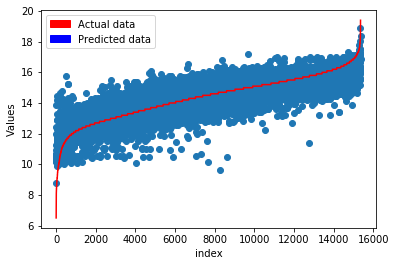

,t + 1,pred (t +1)
2584,18.3,17.204504
12722,18.3,16.289117
4854,18.3,16.269928
1517,18.4,16.959042
5438,18.4,17.553932
8884,18.7,18.049000
6730,18.7,16.973407
6667,18.9,18.897732
14511,19.3,16.846647
5533,19.4,18.371330


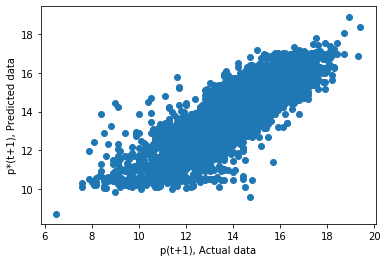

In [21]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

xg boost
==========

In [22]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

XGBRegressor(alpha=200, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=10,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [23]:

ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


mean_squared_error 0.5686034577377265
root mean_squared_error 0.7540579936170204
mean_absolute_error 0.5779502080240156
r2_score 0.7367540000439432


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)